In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from IPython.display import Markdown as md
from matplotlib_venn import venn3, venn2
from tracking_grants.utils.helpers import load_references, load_articles, load_metrics, load_awards, load_grants, load_trials

In [5]:
# sns.set_context("notebook")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [38]:
refs = load_references()
articles = load_articles()
metrics = load_metrics()
awards = load_awards()
trials = load_trials()
grants = load_grants()

In [39]:
# Some report-specific processing

# remove some observations from dataset
# grants = grants[grants.program!="PRORP"]
grants = grants[grants.award_amount!=0]
grants.wos_citations = grants.wos_citations.replace(0, None)

# award categories coded by Lauren
grant_cats = pd.read_excel("/home/asura/Projects/scholcommlab/tracking-grants/data/external/CDRMP_award_types.xlsx")
df = grant_cats.category.dropna().map(lambda x: [s.strip() for s in x.split("/")])
cats = grant_cats[['award type', 'publication count']].join(df.to_frame().explode("category"), how="right")
grants = grants.merge(cats[['award type', 'category']], left_on="type", right_on="award type", how="left")
grants.loc[grants.category.isna(), 'category'] = "Other"

## Tracking CDMRP Awards: A pilot

*Juan Pablo Alperin, Asura Enkhbayar, Lauren Maggio*

---

Project repository with code, data, and other materials: [Github](https://github.com/ScholCommLab/tracking-grants)

<img style="float: right;" width=35%, src="SCL.png">

## Part 0 - Goals/Overview

### We hope this pilot data can...

- enhance CDMRP's current data set by providing additional metadata (e.g., PMID, PMCID, DOI)
- extend CDMRP's data set to include Altmetric indicators (e.g., Twitter accounts, Facebook posts), clinical trial data and open access status
- provide a sense of future areas of exploration

### We are not ...

- providing a detailed assessment of grants, papers, or programs
- evaluating the quality of the work, efficiency of the programs, or measuring if they are meeting their stated objectives. 

**Citations ≠ quality, Altmetrics ≠ public value, News ≠ saliency**

## Part 1 - Data Gathering and Enhancement

### Overview of the data pipeline

![](tracking_grants_flowchart.png)

### Input data and matched results

In [20]:
def research_programs_intro():
    labels = {
        'PCRP': 'Prostate Cancer Research Program',
        'NFRP': 'Neurofibromatosis Research Program',
        'PRORP': 'Peer Reviewed Orthopaedic Research Program',
        'TSCRP': 'Tuberous Sclerosis Complex Research Program'
    }
    df = refs.program.value_counts().to_frame("References")
    df['Articles'] = articles.program.value_counts()
    df['Awards'] = grants.drop_duplicates("grant_id").program.value_counts()
    df.index = [f"{labels[_]} ({_})" for _ in df.index]
    return df

In [21]:
research_programs_intro()

,References,Articles,Awards
Prostate Cancer Research Program (PCRP),8315,7434,1976
Neurofibromatosis Research Program (NFRP),648,624,186
Peer Reviewed Orthopaedic Research Program (PRORP),354,335,95
Tuberous Sclerosis Complex Research Program (TSCRP),208,202,85


### Publications and awards over years

In [9]:
def plot_awards_pubs_over_years():
    df = articles.drop_duplicates("DOI").created.value_counts().to_frame("Publications")
    df['Awards'] = awards.award_year.value_counts()
    df.index.name = "Year"
    df = df.reset_index().melt(id_vars="Year", value_name="Count", var_name="Type")
    sns.barplot(x="Year", y="Count", hue="Type", data=df)
    plt.savefig("plot_awards_pubs_over_years.png")

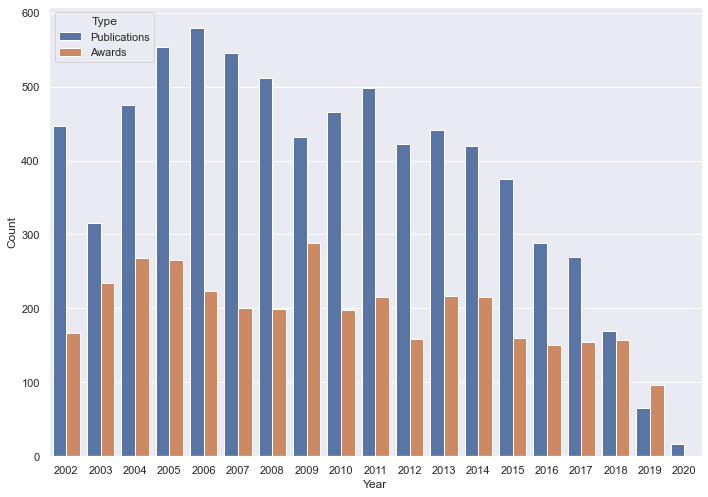

In [10]:
plot_awards_pubs_over_years()

### Reference matching

In [11]:
s = f"""
- Total number of references: {len(refs)}
- References that were found in Crossref: {articles.reference_id.nunique()}
- These references were matched to {articles.DOI.nunique()} articles
"""
md(s)


- Total number of references: 9525
- References that were found in Crossref: 8595
- These references were matched to 7289 articles


### Coverage of references found in Crossref

In [12]:
def venn_refs():
    all_articles = set(refs.reference_id.unique().tolist())
    articles_w_altm = set(articles.reference_id.unique().tolist())

    total = len(all_articles)

    v = venn2([all_articles, articles_w_altm],
          set_labels=('', ''),
          subset_label_formatter=lambda x: "{:,} ({:.1f}%)".format(x, 100*x/total));

    v.get_patch_by_id('10').set_color(cp3[0])
    v.get_patch_by_id('11').set_color(np.add(cp3[0], cp3[1])/2)
#     v.get_patch_by_id('001').set_color(np.add(cp3[0], cp3[2])/2)
#     v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

    for text in v.set_labels:
        text.set_fontsize(10)
    # for text in v.subset_labels:
    #     text.set_fontsize(12)

    handles = []
    labels=["Total references", "Found in Crossref"]
    for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles);
    plt.savefig("venn_refs.png")

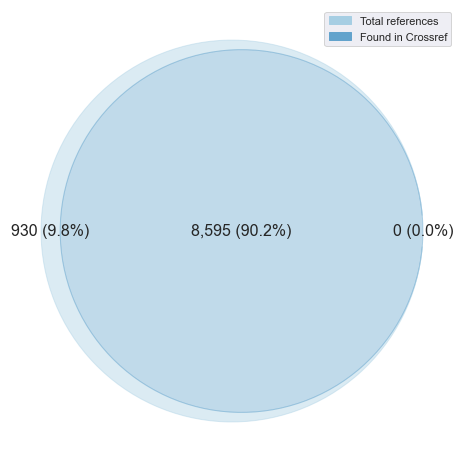

In [13]:
venn_refs()

### Coverage of DOIs (n=7289) in the WoS (21.9%) and Twitter (39.1%)

In [96]:
def venn_metrics():
    all_articles = set(articles.DOI.unique().tolist())
    articles_w_altm = set(metrics[metrics.twitter_accounts.notna()].DOI.unique().tolist())
    articles_w_cit = set(metrics[metrics.wos_citations.notna()].DOI.unique().tolist())

    total = len(all_articles)

    v = venn3([all_articles, articles_w_altm, articles_w_cit],
          set_labels=('', '', ''),
          subset_label_formatter=lambda x: "{:,} ({:.1f}%)".format(x, 100*x/total));

    v.get_patch_by_id('100').set_color(cp3[0])
    v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
    v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)
    v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

    for text in v.set_labels:
        text.set_fontsize(10)
    # for text in v.subset_labels:
    #     text.set_fontsize(12)

    handles = []
    labels=["Articles found", "WoS", "Twitter"]
    for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles);
    plt.savefig("venn_metrics.png")

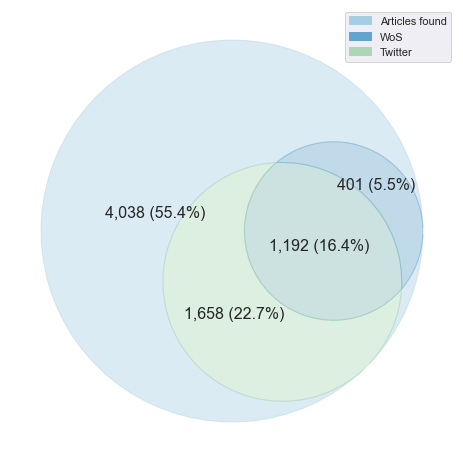

In [97]:
venn_metrics()

### Clinical Trials

In [94]:
def clinical_trials_intro():
    col_order = ["Early Phase 1", "Phase 1", "Phase 2", "Phase 3", "Phase 4", "Not Applicable"]
    df = trials.Phase.value_counts().reindex(col_order[::-1])
    df.index = [f"{_} (n={df[_]})" for _ in df.index]
    df.plot(kind="barh")
    plt.tight_layout()
    plt.savefig("clinical_trials.png")

In [17]:
s = f"""We found **{len(trials)} clinical trials** via clinicaltrials.gov.

These trials were associated with {trials.doi.nunique()} articles in our dataset funded by **{articles[articles.DOI.isin(trials.doi)].grant_id.nunique()} grants**.
"""
md(s)

We found **301 clinical trials** via clinicaltrials.gov.

These trials were associated with 231 articles in our dataset funded by **182 grants**.


#### Breakdown of trials (n=301) by phases

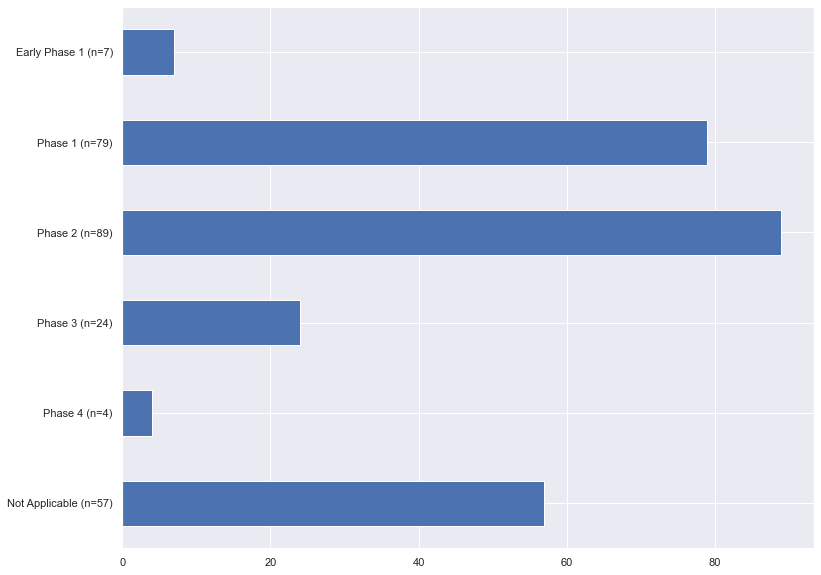

In [95]:
clinical_trials_intro()

## Part 2 - Data on the award level

#### Overview of awards per research program

In [90]:
def awards_intro():
    df = grants.drop_duplicates("grant_id").program.value_counts().to_frame("Awards")
    df['Avg Size [millions]'] = grants.drop_duplicates("grant_id").groupby("program").award_amount.mean()
    return df.round(2)

In [91]:
awards_intro()

,Awards,Avg Size [millions]
PCRP,1976,0.46
NFRP,186,0.94
PRORP,95,1.35
TSCRP,85,0.45


### Number of publications per research program

In [88]:
def pubs_per_award():    
    df = grants[['grant_id', 'program', 'award_amount', 'n_dois']].copy()
    df = df.drop_duplicates()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="n_dois", x="program", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100, 200]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Publications per grant");
    plt.tight_layout()
    plt.savefig("pubs_per_grant.png")

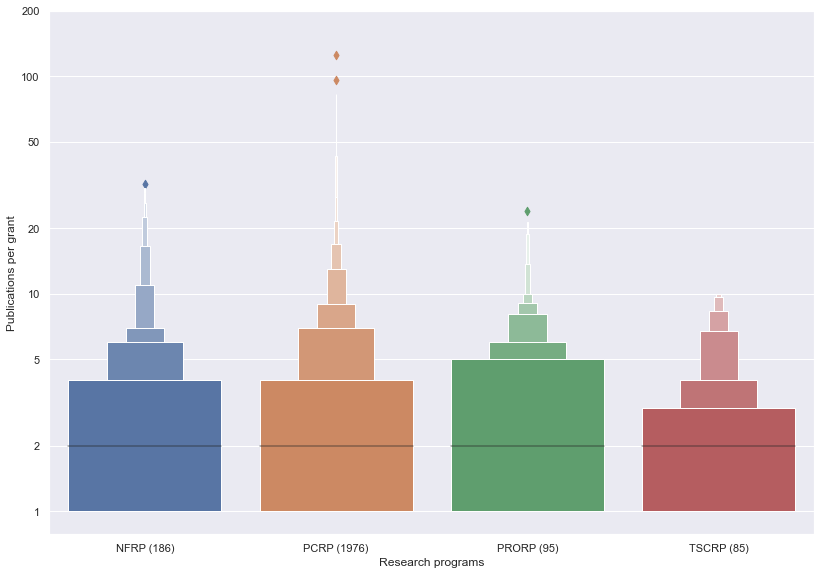

In [89]:
pubs_per_award()

### Award amount per research program

In [86]:
def dollars_per_award():    
    df = grants[['grant_id', 'program', 'award_amount', 'n_dois']].copy()
    df = df.drop_duplicates()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="award_amount", x="program", data=df)
    plt.yscale("log")
    ticks = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Award amount in $ (millions)");
    plt.tight_layout()
    plt.savefig("dollars_per_grant.png")

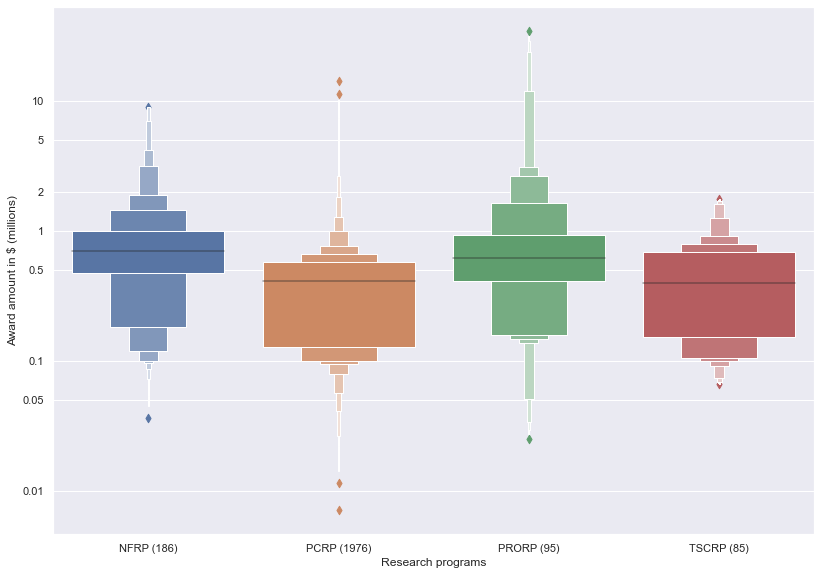

In [87]:
dollars_per_award()

### Award types

Manual categorization of 90+ mechanism types across all research programs

In [71]:
def award_category_overview():
    labels = {
        'ECR': 'Early Career Researchers Awards (Training, Fellowships, etc.)',
        'Idea': 'Idea and Concept Development',
        'Clinical Trial': 'Clinical Trial Awards',
        'Consortium': '(Clinical) Consortium Awards',
        'Health Disparity': 'Health Disparity Awards',
        'HBCU': 'Historically Black Colleges and Universities',
        'Non-academic': 'E.g., Training for Physicians',
        'Research Site': 'Development of centers and other research sites',
        'Impact': 'Impact Awards',
        'Other': 'Other Awards',
    }
    counts = grants.category.value_counts()
    df = pd.DataFrame(index=counts.index.tolist())
    df['Categorization'] = df.index.map(lambda x: labels[x])
    df['Awards'] = counts
    df['Avg. size [millions]'] = grants.groupby("category").award_amount.mean() 
    return df.round(2)

In [72]:
award_category_overview()

,Categorization,Awards,Avg. size [millions]
Idea,Idea and Concept Development,1176,0.49
ECR,"Early Career Researchers Awards (Training, Fel...",861,0.27
Other,Other Awards,178,0.96
Non-academic,"E.g., Training for Physicians",61,0.65
Health Disparity,Health Disparity Awards,59,0.48
HBCU,Historically Black Colleges and Universities,58,0.51
Consortium,(Clinical) Consortium Awards,44,3.51
Research Site,Development of centers and other research sites,40,1.25
Impact,Impact Awards,22,1.99
Clinical Trial,Clinical Trial Awards,18,1.22


### Award size vs number of publications (without Consortia, Research Site)

In [75]:
def award_percentiles(metric, label, log=False, program=None):
    df = grants[grants.category.notna()]
    df = df.drop_duplicates("grant_id")
    df = df[~df.category.isin(["Consortium", "Research Site"])]
    if program:
        df = df[df.program==program]
    
    award_90th = df.award_amount.quantile(.9)
    award_99th = df.award_amount.quantile(.99)
    
    metric_90th = df[metric].quantile(.9)
    metric_99th = df[metric].quantile(.99)
    
    sns.lmplot(x="award_amount", y=metric, hue="category", data=df, height=8, aspect=1.4, fit_reg=False, scatter_kws={'alpha':.7})

    plt.hlines(metric_90th, 0, award_90th, linestyles="--")
    plt.hlines(metric_99th, 0, award_99th, linestyles="--")

    plt.vlines(award_90th, 0, metric_90th, linestyles="--")
    plt.vlines(award_99th, 0, metric_99th, linestyles="--")

    plt.text(-.3, metric_90th, "90th", fontdict={'size':12});
    plt.text(-.3, metric_99th, "99th", fontdict={'size':12});
    
    if log:
        plt.yscale("log")
    
    plt.ylabel(label)
    plt.xlabel("Size of award in $ (millions)")
    plt.savefig("grant_percentiles.png")

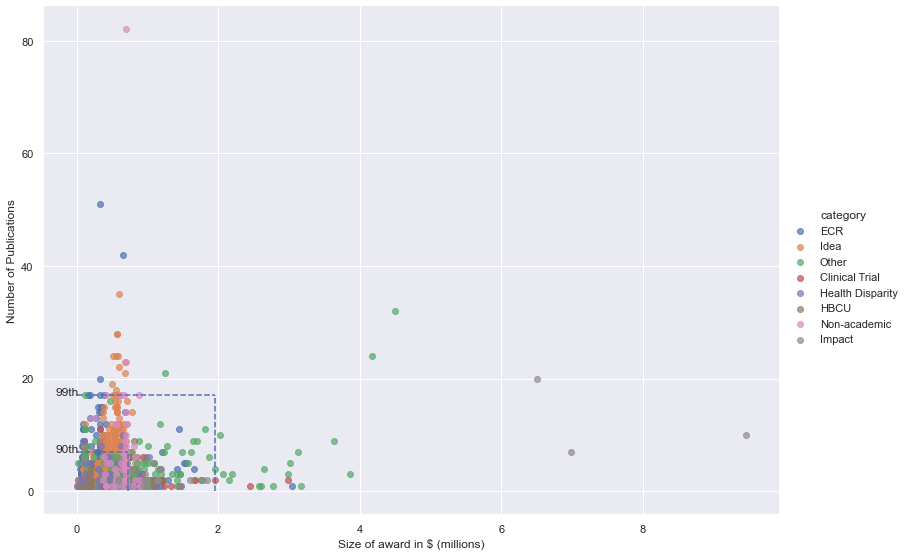

In [76]:
award_percentiles("n_dois", "Number of Publications", program=None)

### Number of publication by award award category

In [38]:
def pubs_per_award_type():    
    df = grants[['program', 'category', 'award_amount', 'n_dois']].copy()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="n_dois", x="program", hue="category", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100]
    plt.yticks(ticks, ticks)
    plt.xlabel("Research programs")
    plt.ylabel("Number of publications");
    plt.savefig("pubs_per_award_type.png")

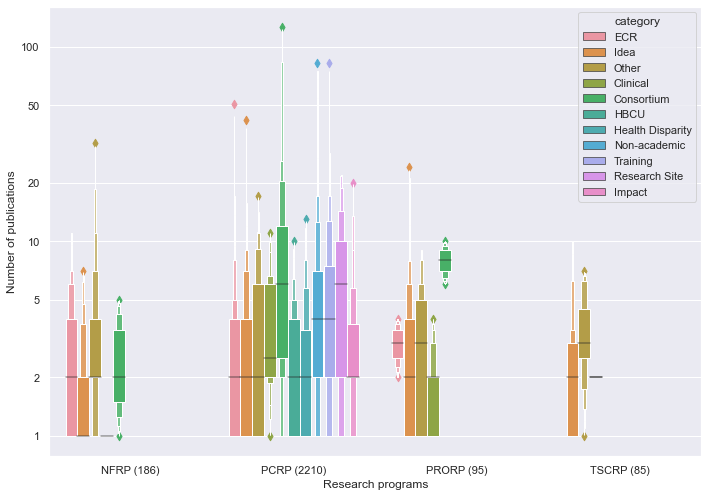

In [39]:
pubs_per_award_type()

### Award amount by categories

In [44]:
def dollars_per_award_type():    
    df = grants[['program', 'category', 'award_amount', 'n_dois']].copy()
    counts = df.program.value_counts()
    df['program'] = df['program'].map(lambda x: f"{x} ({counts[x]})")
    
    sns.boxenplot(y="award_amount", x="program", hue="category", data=df)
    plt.yscale("log")
    ticks = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    plt.yticks(ticks, ticks);
    plt.xlabel("Research programs")
    plt.ylabel("Award amount in $ (millions)");
    plt.savefig("dollars_per_award_type.png")    

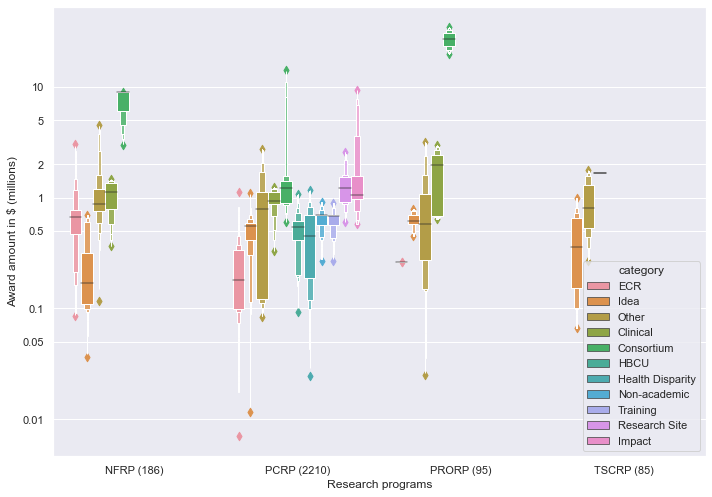

In [45]:
dollars_per_award_type()

## Part 3 - Not all awards are the same

### Measuring award outputs

In [48]:
def plot_metrics(cols):
    df = grants.drop_duplicates("grant_id")[cols]
    df = df.melt(id_vars="program", var_name="Metric", value_name="Count")
    # sns.boxplot(x="Metric", y="Count", data=df)
    sns.boxenplot(x="Metric", y="Count", hue="program", data=df)
    plt.yscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
    plt.yticks(ticks, ticks);
    plt.xticks(rotation=30, ha="right")
    plt.xlabel("Metrics")
    plt.ylabel("Counts");
    plt.savefig("metrics.png")
    
selected_metrics = ['program', 'wos_citations', 'twitter_accounts', 'patents', 'news_outlets', 'blogs', 'fb_pages',
       'videos', 'reddit_threads', 'policies', 'wikipedia', 'n_trials', 'n_dois',]

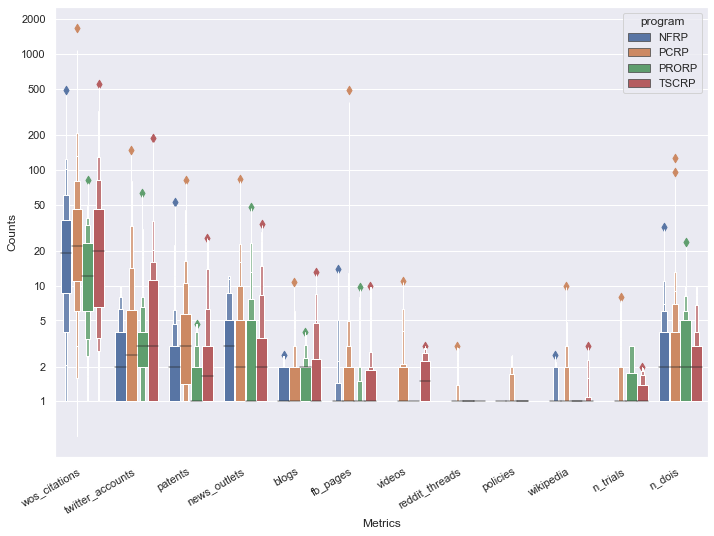

In [49]:
plot_metrics(selected_metrics)

### Pairplot on the award level

In [32]:
def pairplots():
    df = grants[['wos_citations', 'twitter_accounts', 'news_outlets', 'category']].copy()
    sns.pairplot(data=df, hue="category", diag_kind="kde", )
    plt.savefig("pairplots.png")

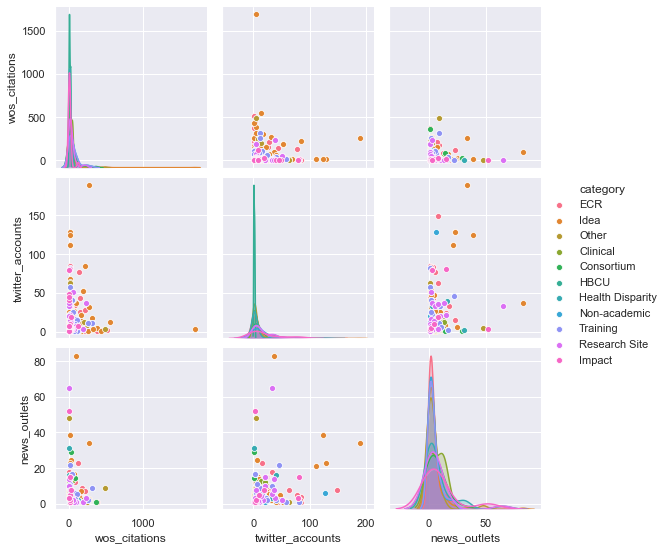

In [33]:
pairplots()

### Outputs over award size

In [34]:
def outputs_per_dollars():
    df = grants[['wos_citations', 'twitter_accounts', 'n_dois', 'category', 'award_amount']].copy()

    df.columns = ["Citations", "Twitter", "Publications", "category", "award_amount"]
    sns.pairplot(df, x_vars="award_amount", y_vars=["Citations", 'Twitter', 'Publications'], hue="category", aspect=3)
    plt.xscale("log")
    ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    plt.xticks(ticks, ticks);
    plt.xlabel("Award size in millions ($)");
    plt.savefig("outputs_per_dollars.png")

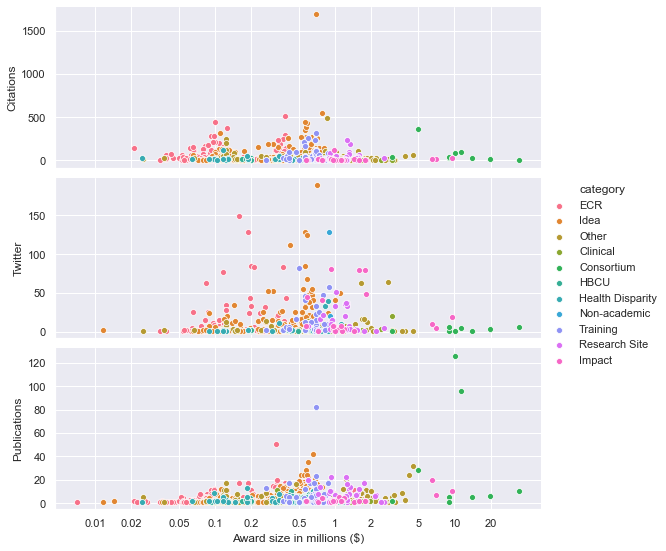

In [35]:
outputs_per_dollars()

## Part 4 - Limitations

### Scope and results

- Current pilot is limited to the 4 selected programs
- Results might differ with different programs

### Data quality and completeness

- We are not fetching papers, only using data provided
- We are matching citation strings to Crossref database: there’s an error rate in this matching
- Citations from WoS only count citing papers from other WoS papers
- Altmetric and Unpaywall are also known to have some errors (as with any database drawn from searching the Web).

## Part 5 - Future Directions

- Data on the Open Access status (through Unpaywall API)
    - Quantify the public access to research outputs generated by research programs
    - Is there an Open Access advantage (citations, altmetrics, other metrics) observeable in the data?
- Provide a more comprehensive overview of identifiers
    - Based on the DOI we are currently retrieving PMIDs
    - Using the same method, we can attempt to retrieve PMCIDs instead of relying on the internal conversion tools provided by the NCBI which have been unreliable